In [2]:

# --- 1. Imports ---
import os, json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models, optimizers

print("TensorFlow version:", tf.__version__)



TensorFlow version: 2.15.0


In [3]:

# --- 2. Paths ---
import os, json
IMG_DIR = "./data/train_data/images"          # your pellet images folder
ANNOT_PATH = "./data/via_export_json.json"
DENSITY_DIR = "./data/train_data/densitymaps"
os.makedirs(DENSITY_DIR, exist_ok=True)


In [7]:
# --- 3. Convert VGG JSON annotations -> density maps ---
import cv2
import numpy as np
# --- 3. Convert VGG JSON annotations -> density maps ---
# --- 3. Convert VGG JSON annotations -> density maps ---
def generate_density_map(img, points, sigma=4, out_size=(64, 64)):
    h, w = img.shape[:2]
    density = np.zeros((h, w), dtype=np.float32)
    for x, y in points:
        if 0 <= x < w and 0 <= y < h:
            density[int(y), int(x)] = 1
    density = gaussian_filter(density, sigma=sigma)

    # 🔹 Resize density map to match model output
    density = cv2.resize(density, out_size, interpolation=cv2.INTER_CUBIC)

    # keep sum consistent after resizing
    if density.sum() > 0:
        density = density * (len(points) / density.sum())

    return density

with open(ANNOT_PATH, "r") as f:
    vgg_data = json.load(f)

for key, val in vgg_data.items():
    filename = val["filename"]
    regions = val["regions"]
    points = []

    for r in regions:
        shape = r["shape_attributes"]
        if shape["name"] == "point":
            x, y = shape["cx"], shape["cy"]
            points.append((x, y))

    img_path = os.path.join(IMG_DIR, filename)
    img = cv2.imread(img_path)
    if img is None:
        print(f"⚠️ Skipping {filename}, image not found in {IMG_DIR}")
        continue

    density = generate_density_map(img, points, out_size=(64, 64))
    out_path = os.path.join(DENSITY_DIR, filename.replace(".jpg", ".npy"))
    np.save(out_path, density)

print("✅ Density maps generated (resized to match model output)")


✅ Density maps generated (resized to match model output)


In [8]:
# --- 5. Prepare training data ---
X_train, Y_train = [], []

for filename in os.listdir(IMG_DIR):
    if not filename.endswith(".jpg"):
        continue

    # input image
    img_path = os.path.join(IMG_DIR, filename)
    img = load_img(img_path, target_size=(512, 512))  # model input
    img = img_to_array(img) / 255.0
    X_train.append(img)

    # density map
    density_path = os.path.join(DENSITY_DIR, filename.replace(".jpg", ".npy"))
    if os.path.exists(density_path):
        dmap = np.load(density_path)
        dmap = np.expand_dims(dmap, axis=-1)   # (64, 64, 1)
        Y_train.append(dmap)

X_train = np.array(X_train, dtype=np.float32)
Y_train = np.array(Y_train, dtype=np.float32)

print("X_train shape:", X_train.shape)  # (N, 512, 512, 3)
print("Y_train shape:", Y_train.shape)  # (N, 64, 64, 1)


X_train shape: (63, 512, 512, 3)
Y_train shape: (63, 64, 64, 1)


In [5]:

# --- 5. Define CSRNet (simplified Keras version) ---
def CSRNet(input_shape=(512, 512, 3)):
    inputs = layers.Input(shape=input_shape)

    # VGG-like frontend
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)

    # Dilated backend
    x = layers.Conv2D(512, 3, dilation_rate=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(512, 3, dilation_rate=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(512, 3, dilation_rate=2, padding="same", activation="relu")(x)

    x = layers.Conv2D(256, 3, dilation_rate=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, 3, dilation_rate=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(64, 3, dilation_rate=2, padding="same", activation="relu")(x)

    # Output density map
    output = layers.Conv2D(1, 1, padding="same", activation="linear")(x)

    model = models.Model(inputs, output)
    return model

model = CSRNet()
model.compile(optimizer=optimizers.Adam(1e-5), loss="mse")
model.summary()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 512, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 256, 256, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 128)     147584    
                                                           

In [10]:

# --- 6. Train CSRNet ---
history = model.fit(
    X_train, Y_train,
    batch_size=4,
    epochs=50,
    validation_split=0.1
)


Epoch 1/50

14/14 [==============================] - 127s 9s/step - loss: 0.3837 - val_loss: 0.1808
Epoch 2/50
14/14 [==============================] - 121s 9s/step - loss: 0.3829 - val_loss: 0.1812
Epoch 3/50
14/14 [==============================] - 121s 9s/step - loss: 0.3828 - val_loss: 0.1809
Epoch 4/50
14/14 [==============================] - 121s 9s/step - loss: 0.3826 - val_loss: 0.1809
Epoch 5/50
14/14 [==============================] - 123s 9s/step - loss: 0.3824 - val_loss: 0.1809
Epoch 6/50
14/14 [==============================] - 122s 9s/step - loss: 0.3822 - val_loss: 0.1808
Epoch 7/50
14/14 [==============================] - 122s 9s/step - loss: 0.3822 - val_loss: 0.1808
Epoch 8/50
14/14 [==============================] - 123s 9s/step - loss: 0.3821 - val_loss: 0.1809
Epoch 9/50
14/14 [==============================] - 125s 9s/step - loss: 0.3820 - val_loss: 0.1812
Epoch 10/50
14/14 [==============================] - 132s 9s/step - loss: 0.3819 - val_loss: 0.1810
Epoch 11

1/1 [==============================] - 1s 1s/step


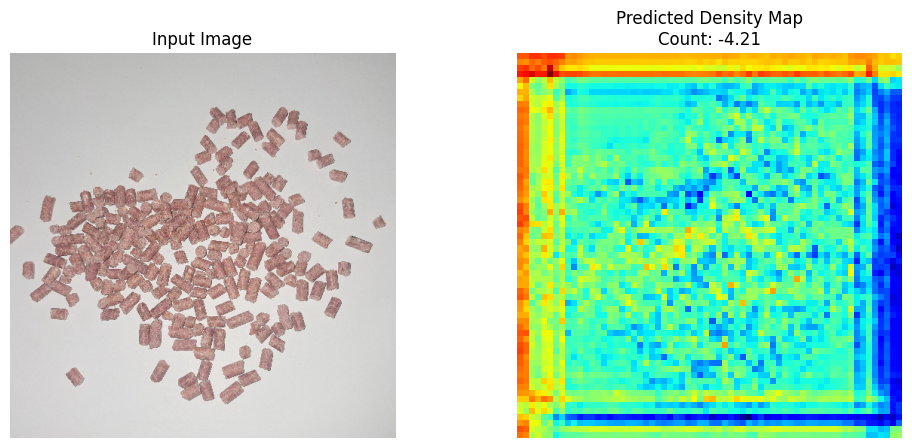

Estimated pellet count: -4.21


In [6]:

# --- 7. Test on a new pellet image ---
test_img_path = "./data/train_data/images/20250829_204644.jpg"   # replace with your test image
img = load_img(test_img_path, target_size=(512, 512))
img_arr = img_to_array(img) / 255.0
img_arr = np.expand_dims(img_arr, axis=0)

pred_density = model.predict(img_arr)
pred_count = np.sum(pred_density)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(pred_density[0,:,:,0], cmap="jet")
plt.title(f"Predicted Density Map\nCount: {pred_count:.2f}")
plt.axis("off")

plt.show()

print(f"Estimated pellet count: {pred_count:.2f}")
